In [1]:
# companion qgis project at -- /home/thistle/Documents/dev/ML/idaho1/data/idaho_springs_i70_1.qgz
# data stored at -- /home/thistle/Documents/dev/ML/idaho1/data/
# project at -- /home/thistle/Documents/dev/ML/idaho1

In [2]:
# %load template.py
# %load template.py
import glob
import io
import ipyleaflet
import IPython.display
import ipyvolume.pylab as p3
import json
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pdal
import PIL
import pyproj
import requests
import fiona
import shapely.geometry
from shapely.geometry import Polygon, mapping
import scipy.spatial
import sys
import urllib.request
from collections import OrderedDict
from fiona.crs import from_epsg

%load_ext autoreload
%autoreload 2
    
sys.path.append('../src')
from idaho1.pcl_utils import local_max
%matplotlib inline

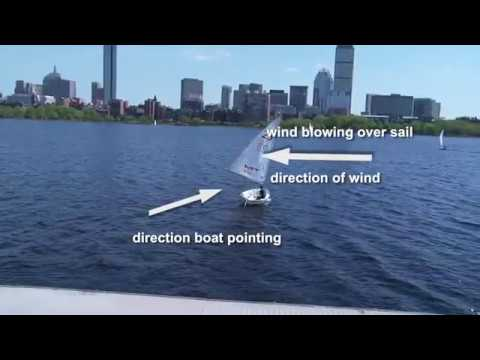

In [3]:
from IPython.display import YouTubeVideo
ytv = "YAeSFwzRETY"
YouTubeVideo(ytv, start=55, autoplay=1, color='white')

In [4]:
# sample filename-- USGS_LPC_CO_SoPlatteRiver_Lot5_2013_13SDD462398_LAS_2015.laz
laz_dir = "/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/" # 6 files

In [5]:
os.listdir(laz_dir)

['outs',
 'USGS_LPC_CO_SoPlatteRiver_Lot5_2013_13SDD459398_LAS_2015.laz',
 'USGS_LPC_CO_SoPlatteRiver_Lot5_2013_13SDD459399_LAS_2015.laz',
 'USGS_LPC_CO_SoPlatteRiver_Lot5_2013_13SDD460398_LAS_2015.laz',
 'USGS_LPC_CO_SoPlatteRiver_Lot5_2013_13SDD460399_LAS_2015.laz',
 'USGS_LPC_CO_SoPlatteRiver_Lot5_2013_13SDD462398_LAS_2015.laz',
 'USGS_LPC_CO_SoPlatteRiver_Lot5_2013_13SDD462399_LAS_2015.laz']

In [11]:
dir(os)
#dir(os.path)

['CLD_CONTINUED',
 'CLD_DUMPED',
 'CLD_EXITED',
 'CLD_TRAPPED',
 'DirEntry',
 'EX_CANTCREAT',
 'EX_CONFIG',
 'EX_DATAERR',
 'EX_IOERR',
 'EX_NOHOST',
 'EX_NOINPUT',
 'EX_NOPERM',
 'EX_NOUSER',
 'EX_OK',
 'EX_OSERR',
 'EX_OSFILE',
 'EX_PROTOCOL',
 'EX_SOFTWARE',
 'EX_TEMPFAIL',
 'EX_UNAVAILABLE',
 'EX_USAGE',
 'F_LOCK',
 'F_OK',
 'F_TEST',
 'F_TLOCK',
 'F_ULOCK',
 'MutableMapping',
 'NGROUPS_MAX',
 'O_ACCMODE',
 'O_APPEND',
 'O_ASYNC',
 'O_CLOEXEC',
 'O_CREAT',
 'O_DIRECT',
 'O_DIRECTORY',
 'O_DSYNC',
 'O_EXCL',
 'O_LARGEFILE',
 'O_NDELAY',
 'O_NOATIME',
 'O_NOCTTY',
 'O_NOFOLLOW',
 'O_NONBLOCK',
 'O_RDONLY',
 'O_RDWR',
 'O_RSYNC',
 'O_SYNC',
 'O_TRUNC',
 'O_WRONLY',
 'POSIX_FADV_DONTNEED',
 'POSIX_FADV_NOREUSE',
 'POSIX_FADV_NORMAL',
 'POSIX_FADV_RANDOM',
 'POSIX_FADV_SEQUENTIAL',
 'POSIX_FADV_WILLNEED',
 'PRIO_PGRP',
 'PRIO_PROCESS',
 'PRIO_USER',
 'P_ALL',
 'P_NOWAIT',
 'P_NOWAITO',
 'P_PGID',
 'P_PID',
 'P_WAIT',
 'PathLike',
 'RTLD_DEEPBIND',
 'RTLD_GLOBAL',
 'RTLD_LAZY',
 'RTLD_LO

In [13]:
laz_files = [file for file in os.listdir(laz_dir) if os.path.isfile(os.path.join(laz_dir, file))]

In [14]:
f0 = os.path.join(laz_dir, laz_files[0])
f0

'/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/USGS_LPC_CO_SoPlatteRiver_Lot5_2013_13SDD459398_LAS_2015.laz'

In [15]:
#!pdal info $f0 --metadata

In [16]:
res = !pdal info $f0 | jq .stats.bbox.native.bbox

In [17]:
res

['{',
 '  "maxx": 460499.99,',
 '  "maxy": 4399499.99,',
 '  "maxz": 3920.4,',
 '  "minx": 459000.01,',
 '  "miny": 4398000,',
 '  "minz": 2238.73',
 '}']

In [18]:
type(res)

IPython.utils.text.SList

In [19]:
r = res.nlstr
r

'{\n  "maxx": 460499.99,\n  "maxy": 4399499.99,\n  "maxz": 3920.4,\n  "minx": 459000.01,\n  "miny": 4398000,\n  "minz": 2238.73\n}'

In [20]:
z = json.loads(r)

In [21]:
type(z)

dict

In [22]:
# lets make a shapefile with a shape of each bounding box for each laz file
# store gis data in ../data/gis/

In [23]:
fp = "../data/gis/"
if not os.path.isdir(fp):
    os.mkdir(fp)
    print("directory made")
else: print("pass")

pass


In [24]:
def make_poly(bbox):
    # bbox is a dictionary with the following keys
    poly = Polygon([(bbox["maxx"], bbox['maxy']), (bbox["maxx"], bbox['miny']), (bbox["minx"], bbox['miny']), (bbox["minx"], bbox['maxy']), (bbox["maxx"], bbox['maxy'])])
    return poly

In [28]:
t = make_poly(z)
str(t)
# looks good


'POLYGON ((460499.99 4399499.99, 460499.99 4398000, 459000.01 4398000, 459000.01 4399499.99, 460499.99 4399499.99))'

In [ ]:
##########
## below is experiments
## what is size of original laz files

In [29]:
# f0 already defined
f1 = os.path.join(laz_dir, laz_files[1])
f2 = os.path.join(laz_dir, laz_files[2])

In [44]:
c0 = !pdal info $f0 --metadata | jq .metadata.count
c1 = !pdal info $f1 --metadata | jq .metadata.count
c2 = !pdal info $f2 --metadata | jq .metadata.count
cs = []

cs.append(c0[0]); cs.append(c1[0]); cs.append(c2[0])
cs = [int(num) for num in cs]
avg = sum(cs)/len(cs)
avg

10830010.0

In [45]:
# use qgis to pick 3 sites of interest
# they are now stored in the shapefile sites.shp located at
# /home/thistle/Documents/dev/ML/idaho1/data/gis/sites_of_interest/sites.shp

In [52]:
sites_fp = "/home/thistle/Documents/dev/ML/idaho1/data/gis/sites_of_interest/sites.shp"
output_file = "/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/outputs/bigLaz.laz"

In [58]:
# add full path to laz_files
full_laz_files = [os.path.join(laz_dir, each) for each in laz_files]
full_laz_files

['/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/USGS_LPC_CO_SoPlatteRiver_Lot5_2013_13SDD459398_LAS_2015.laz',
 '/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/USGS_LPC_CO_SoPlatteRiver_Lot5_2013_13SDD459399_LAS_2015.laz',
 '/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/USGS_LPC_CO_SoPlatteRiver_Lot5_2013_13SDD460398_LAS_2015.laz',
 '/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/USGS_LPC_CO_SoPlatteRiver_Lot5_2013_13SDD460399_LAS_2015.laz',
 '/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/USGS_LPC_CO_SoPlatteRiver_Lot5_2013_13SDD462398_LAS_2015.laz',
 '/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/USGS_LPC_CO_SoPlatteRiver_Lot5_2013_13SDD462399_LAS_2015.laz']

In [59]:
# task one -- make dems and 4 hillshades for each site

# make one big laz- why?
# for each cropped polygon dont need to redo it
pipeline = {
    "pipeline":[
        full_laz_files[0],
        full_laz_files[1],
        full_laz_files[2],
        full_laz_files[3],
        full_laz_files[4],
        full_laz_files[5],
        {
            "type":"filters.merge"
        },
        {
            "type":"writers.las",
            "compression":"laszip",
            "filename":output_file
        }
    ]
}
p1 = pdal.Pipeline(json.dumps(pipeline))

p1.validate()

True

In [60]:
%%time
numpts = p1.execute()
print(f"{numpts} processed")

63241360 processed
CPU times: user 1min 13s, sys: 1.53 s, total: 1min 14s
Wall time: 1min 18s


In [61]:
output_file

'/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/outputs/bigLaz.laz'

In [63]:
# check size 60 million ?
!pdal info $output_file --metadata # yup
# so use this file for further pipelines

{
  "filename": "/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/outputs/bigLaz.laz",
  "metadata":
  {
    "comp_spatialreference": "COMPD_CS[\"unknown\",PROJCS[\"NAD83 / UTM zone 13N\",GEOGCS[\"NAD83\",DATUM[\"North_American_Datum_1983\",SPHEROID[\"GRS 1980\",6378137,298.257222101,AUTHORITY[\"EPSG\",\"7019\"]],AUTHORITY[\"EPSG\",\"6269\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AUTHORITY[\"EPSG\",\"4269\"]],PROJECTION[\"Transverse_Mercator\"],PARAMETER[\"latitude_of_origin\",0],PARAMETER[\"central_meridian\",-105],PARAMETER[\"scale_factor\",0.9996],PARAMETER[\"false_easting\",500000],PARAMETER[\"false_northing\",0],UNIT[\"metre\",1,AUTHORITY[\"EPSG\",\"9001\"]],AXIS[\"Easting\",EAST],AXIS[\"Northing\",NORTH],AUTHORITY[\"EPSG\",\"26913\"]],VERT_CS[\"NAVD88 height\",VERT_DATUM[\"North American Vertical Datum 1988\",2005,AUTHORITY[\"EPSG\",\"5103\"]],UNIT[\"metre\",1,AUTHORITY[\"EPSG\",\"9001\"]],AX

In [77]:
minx = !pdal info $output_file --metadata | jq .metadata.minx
maxx = !pdal info $output_file --metadata | jq .metadata.maxx


miny = !pdal info $output_file --metadata | jq .metadata.miny
maxy = !pdal info $output_file --metadata | jq .metadata.maxy


In [78]:
maxy= maxy[0]
maxx = maxx[0]
minx = minx[0]
miny = miny[0]

In [80]:
diff_y = float(maxy) - float(miny)
diff_x = float(maxx) - float(minx)
diff_x, diff_y

(4499.979999999981, 3000.0)

In [ ]:
# get sites(Polygons)


In [117]:
polys = [];
with fiona.open(sites_fp, "r",) as f:
    for each in f:
        polys.append(each)

In [107]:
a = polys[2]

In [112]:
a['properties']['name']

'bridge'

In [96]:
p1 = Polygon(a)

In [98]:
p1.to_wkt()

'POLYGON ((462448.0320097281364724 4399742.9502351656556129, 462551.1302799984696321 4399477.1858051354065537, 462326.6051580764469691 4399053.3373606912791729, 461979.5076481664436869 4399214.8579841144382954, 461917.6486860042787157 4399379.8152165468782187, 462448.0320097281364724 4399742.9502351656556129))'

for each of the areas of interest
run a pipeline and output a clipped las
and a dem gtif

In [138]:
poly_tups = []
for poly in polys:
    name = poly['properties']['name']
    coords = poly['geometry']['coordinates']
    poly_tups.append((name, coords[0]))
    
    

In [142]:
%%time
output_dir = "/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/outputs/clipped"

for each in poly_tups:
    clipped_out_file = os.path.join(output_dir, each[0] + ".las")
    apoly = Polygon(each[1])

    pipe = {
        "pipeline":[
            {
                "type":"readers.las",
                "filename":output_file
            },
            {
                "type":"filters.crop",
                "polygon": apoly.to_wkt()
            },
            {
                "type":"writers.las",
                "filename": clipped_out_file
            }]}
    pp = pdal.Pipeline(json.dumps(pipe))
    numpts = pp.execute()
    print(f"file {each[0]} written")
    print(f"{numpts} processed")
    

file tunnel written
2700540 processed
file gulch written
2695974 processed
file bridge written
1482006 processed
CPU times: user 2min 23s, sys: 1.82 s, total: 2min 25s
Wall time: 2min 25s


In [ ]:
# pipeline to fine ground pts for each file in a dir



In [149]:
filenames = os.listdir(output_dir)
filenames

['bridge.las', 'gulch.las', 'tunnel.las']

In [152]:
out_tiff_dir = "/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/outputs/clipped/tiffs/"

In [159]:
%%time
for name in filenames:
    site_file = os.path.join(output_dir, name)
    # print(site_file)
    out_file = os.path.join(out_tiff_dir, name.split(".")[0] + ".tif")
    # print(out_file)
    pipeline2 = {
    "pipeline":[
        {
            "type":"readers.las",
            "filename":site_file
        },
        {  "type":"filters.outlier",
           "method":"statistical",
           "mean_k":"8",
           "multiplier":"3"
        },
        {
           "type":"filters.smrf"
        },
        {
           "type":"filters.range",
           "limits":"Classification[2:2]"
        },
        {
           "type":"filters.delaunay"
        },
        {
          "type": "writers.gdal",
          "gdaldriver": "GTIFF",
          "output_type": "all",
          "resolution": "2.0",
          "filename": out_file
      }
  ]}
    pp = pdal.Pipeline(json.dumps(pipeline2))
    numpts = pp.execute()
    print(f"{out_file.split('/')[-1]} written to file")
    print(f"{numpts} processed")
    

bridge.tif written to file
910221 processed
gulch.tif written to file
1507490 processed
tunnel.tif written to file
1755121 processed
CPU times: user 1min 28s, sys: 273 ms, total: 1min 28s
Wall time: 1min 28s


In [163]:

tif_dir = "/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/outputs/clipped/tiffs/"
files_to_hs = os.listdir(tif_dir)
files_to_hs

['bridge.tif', 'gulch.tif', 'tunnel.tif']

In [168]:
%%time
for i, tif in enumerate(files_to_hs):
    file_in = os.path.join(tif_dir, tif)
    #print(file_in)
    hs_dir = "/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/outputs/clipped/tiffs/hs"
    
    #print(file_out)
    angles = [45,135,225,315]
    for angle in angles:
        file_out = os.path.join(hs_dir, tif.split(".")[0] + "_hs_" + str(angle) + ".tif")
        !gdaldem hillshade $file_in $file_out -z 1.0 -s 1.0 -az $angle -alt 45.0 -of GTiff
        print(f"{file_out} created")
        

0...10...20...30...40...50...60...70...80...90...100 - done.
/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/outputs/clipped/tiffs/hs/bridge_hs_45.tif created
0...10...20...30...40...50...60...70...80...90...100 - done.
/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/outputs/clipped/tiffs/hs/bridge_hs_135.tif created
0...10...20...30...40...50...60...70...80...90...100 - done.
/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/outputs/clipped/tiffs/hs/bridge_hs_225.tif created
0...10...20...30...40...50...60...70...80...90...100 - done.
/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/outputs/clipped/tiffs/hs/bridge_hs_315.tif created
0...10...20...30...40...50...60...70...80...90...100 - done.
/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/outputs/clipped/tiffs/hs/gulch_hs_45.tif created
0...10...20...30...40...50...60...70...80...90...100 - done.
/media/thistle/Passport/gis/Idaho_Springs/lidar_downloads/outputs/clipped/tiffs/hs/gulch_hs_

In [143]:
pipeline2 = {
    "pipeline":[
        {
            "type":"readers.las",
            "filename":site_file
        },
        {  "type":"filters.outlier",
           "method":"statistical",
           "mean_k":"8",
           "multiplier":"3"
        },
        {
           "type":"filters.smrf"
        },
        {
           "type":"filters.range",
           "limits":"Classification[2:2]"
        },
        {
           "type":"filters.delaunay"
        },
        {
          "type": "writers.gdal",
          "gdaldriver": "GTIFF",
          "output_type": "all",
          "resolution": "2.0",
          "filename": out_file
      }
  ]}